In [29]:
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from tqdm.auto import tqdm
from PIL import Image
from accelerate import Accelerator

import gc
gc.collect()
torch.cuda.empty_cache()

In [30]:
# accelerator = Accelerator()
# device = accelerator.device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_epochs = 30
batch_size = 30
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

cuda


In [31]:
trainset = datasets.ImageFolder('/kaggle/input/cvdlhw2/Dataset_OpenCvDl_Hw2_Q5/training_dataset/', transform = transform)
testset = datasets.ImageFolder('/kaggle/input/cvdlhw2/Dataset_OpenCvDl_Hw2_Q5/validation_dataset/', transform= transform)

In [32]:
train_loader = torch.utils.data.DataLoader(trainset
    , batch_size = batch_size
    , shuffle = True)
test_loader = torch.utils.data.DataLoader(testset
    , batch_size = batch_size
    , shuffle = True)

In [33]:
train_total_step = len(train_loader)
test_total_step = len(test_loader)
print(train_total_step, test_total_step)

540 60


torch.Size([30, 3, 224, 224])
tensor([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 1])


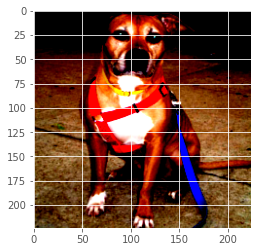

Label: 1


In [34]:
images, labels = next(iter(train_loader))
import matplotlib.pyplot as plt
print(images.shape)
print(labels)
plt.imshow(images[1].permute(1,2,0))
plt.show()
print(f"Label: {labels[1]}")

In [35]:
# from torchsummary import summary
model = torchvision.models.resnet50(pretrained = False)
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Linear(nr_filters, 1)

In [36]:
model = model.to(device)
# loss_function = torchvision.ops.sigmoid_focal_loss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                        lr = learning_rate, 
                        momentum=0.9,
                        weight_decay=5e-4)

# model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

In [37]:
H = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in range(num_epochs): # 
    # set the model in training mode
    model.train()
    total_train_loss = 0
    total_test_loss = 0
    train_correct = 0
    test_correct = 0
    # loop over the training set
    for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = model(x)
        y = y.unsqueeze(1).float()

        # 1. focal loss
        loss = torchvision.ops.sigmoid_focal_loss(pred, y, alpha=0.4, gamma=1.0, reduction='mean')
        # 2. BSE loss
#         m = nn.Sigmoid()
#         criterion = nn.BCELoss()
#         loss = criterion(m(pred), y)


        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        optimizer.zero_grad()
        loss.backward()
#         accelerator.backward(loss)
        optimizer.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        total_train_loss += float(loss)
        # print(loss)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        train_correct += (pred == y).type(torch.float).sum().item()
        # print("train_correct", train_correct)
        # print("train:", (pred == y).type(torch.float).sum().item()/batch_size)
  
    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for i, (x, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
            # perform a forward pass and calculate the training loss
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            y = y.unsqueeze(1).float()
            # send the input to the device

            # 1. focal loss
            loss = torchvision.ops.sigmoid_focal_loss(pred, y, alpha=0.4, gamma=1.0, reduction='mean')
            # 2. BSE loss
#             m = nn.Sigmoid()
#             criterion = nn.BCELoss()
#             loss = criterion(m(pred), y)

            total_test_loss += float(loss)
            pred[pred >= 0.5] = 1
            pred[pred < 0.5] = 0
            test_correct += (pred == y).type(torch.float).sum().item()
            # print("test_correct", test_correct)
            # print("test:", (pred == y).type(torch.float).sum().item()/batch_size)

    # calculate the average training and validation loss
    avg_train_loss = total_train_loss / train_total_step
    avg_test_loss = total_test_loss / test_total_step

    # calculate the training and validation accuracy
    train_correct = train_correct / len(train_loader.dataset)
    test_correct = test_correct / len(test_loader.dataset)

    # update our training history
#     H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    H["train_loss"].append(avg_train_loss)
    H["train_acc"].append(train_correct)
#     H["test_loss"].append(avg_test_loss.cpu().detach().numpy())
    H["test_loss"].append(avg_test_loss)
    H["test_acc"].append(test_correct)

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, num_epochs))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avg_train_loss, train_correct))
    print("Test loss: {:.6f}, Test accuracy: {:.4f}\n".format(avg_test_loss, test_correct))

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 1/30
Train loss: 0.167022, Train accuracy: 0.3917
Test loss: 0.209750, Test accuracy: 0.3267



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 2/30
Train loss: 0.165014, Train accuracy: 0.4174
Test loss: 0.153507, Test accuracy: 0.3356



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 3/30
Train loss: 0.159004, Train accuracy: 0.4254
Test loss: 0.157072, Test accuracy: 0.5889



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 4/30
Train loss: 0.159755, Train accuracy: 0.4649
Test loss: 0.158377, Test accuracy: 0.3622



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 5/30
Train loss: 0.158346, Train accuracy: 0.4902
Test loss: 0.169137, Test accuracy: 0.3511



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 6/30
Train loss: 0.155790, Train accuracy: 0.5108
Test loss: 0.157788, Test accuracy: 0.3983



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 7/30
Train loss: 0.153099, Train accuracy: 0.5181
Test loss: 0.143847, Test accuracy: 0.6628



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 8/30
Train loss: 0.149097, Train accuracy: 0.5414
Test loss: 0.162892, Test accuracy: 0.7033



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 9/30
Train loss: 0.150475, Train accuracy: 0.5564
Test loss: 0.147210, Test accuracy: 0.7028



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 10/30
Train loss: 0.145670, Train accuracy: 0.5806
Test loss: 0.147858, Test accuracy: 0.4650



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 11/30
Train loss: 0.141820, Train accuracy: 0.5903
Test loss: 0.134218, Test accuracy: 0.6483



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 12/30
Train loss: 0.142808, Train accuracy: 0.5994
Test loss: 0.135154, Test accuracy: 0.6956



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 13/30
Train loss: 0.138532, Train accuracy: 0.6146
Test loss: 0.126010, Test accuracy: 0.6078



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 14/30
Train loss: 0.134712, Train accuracy: 0.6210
Test loss: 0.134697, Test accuracy: 0.5511



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 15/30
Train loss: 0.133271, Train accuracy: 0.6330
Test loss: 0.123819, Test accuracy: 0.6833



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 16/30
Train loss: 0.130230, Train accuracy: 0.6451
Test loss: 0.146545, Test accuracy: 0.7389



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 17/30
Train loss: 0.127612, Train accuracy: 0.6565
Test loss: 0.123838, Test accuracy: 0.6800



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 18/30
Train loss: 0.126099, Train accuracy: 0.6695
Test loss: 0.122043, Test accuracy: 0.6633



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 19/30
Train loss: 0.123837, Train accuracy: 0.6756
Test loss: 0.153800, Test accuracy: 0.5372



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 20/30
Train loss: 0.122232, Train accuracy: 0.6838
Test loss: 0.119996, Test accuracy: 0.6694



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 21/30
Train loss: 0.117012, Train accuracy: 0.7041
Test loss: 0.126032, Test accuracy: 0.7394



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 22/30
Train loss: 0.117724, Train accuracy: 0.7043
Test loss: 0.131891, Test accuracy: 0.6389



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 23/30
Train loss: 0.111153, Train accuracy: 0.7203
Test loss: 0.132203, Test accuracy: 0.6117



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 24/30
Train loss: 0.108186, Train accuracy: 0.7343
Test loss: 0.145622, Test accuracy: 0.7500



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 25/30
Train loss: 0.108162, Train accuracy: 0.7370
Test loss: 0.131746, Test accuracy: 0.6467



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 26/30
Train loss: 0.100042, Train accuracy: 0.7565
Test loss: 0.122985, Test accuracy: 0.6822



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 27/30
Train loss: 0.097565, Train accuracy: 0.7688
Test loss: 0.126224, Test accuracy: 0.6544



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 28/30
Train loss: 0.092749, Train accuracy: 0.7818
Test loss: 0.114624, Test accuracy: 0.7161



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 29/30
Train loss: 0.091964, Train accuracy: 0.7862
Test loss: 0.112817, Test accuracy: 0.7350



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 30/30
Train loss: 0.083729, Train accuracy: 0.8056
Test loss: 0.115735, Test accuracy: 0.7478



In [38]:
print(H["train_loss"])
print(H["train_acc"])
print(H["test_loss"])
print(H["test_acc"])

[0.16702153744796913, 0.1650144577992183, 0.15900383920029357, 0.15975489630191414, 0.1583460440652238, 0.15579035541525593, 0.1530994383411275, 0.14909685364475958, 0.1504746384366795, 0.14567047829429308, 0.14181966952703617, 0.14280845188984165, 0.13853156459000376, 0.13471180586903184, 0.13327119662253945, 0.13023025467991828, 0.1276117755583039, 0.12609879461427528, 0.12383676198897538, 0.12223214155269993, 0.11701233768490729, 0.11772358638958799, 0.11115260209750247, 0.10818601939137336, 0.10816197293224158, 0.10004194766558983, 0.0975652980721659, 0.0927494921962972, 0.09196352004590962, 0.08372871409756717]
[0.3917283950617284, 0.4174074074074074, 0.4254320987654321, 0.46487654320987654, 0.4902469135802469, 0.5108024691358025, 0.5181481481481481, 0.5413580246913581, 0.556358024691358, 0.5805555555555556, 0.5903086419753086, 0.5994444444444444, 0.614567901234568, 0.6210493827160494, 0.632962962962963, 0.6450617283950617, 0.6565432098765432, 0.6695061728395062, 0.675555555555555

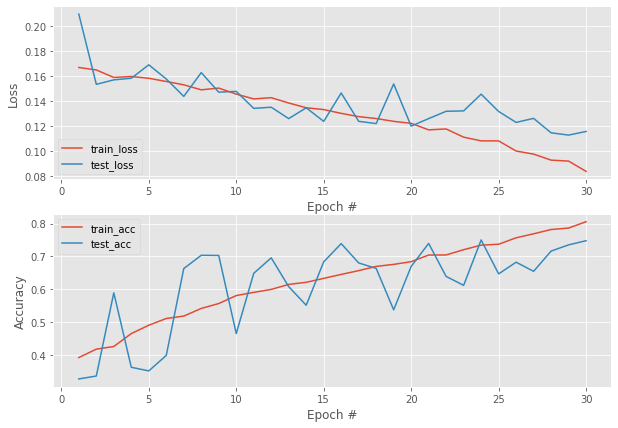

In [39]:
import matplotlib.pyplot as plt

# plot the training loss and accuracy
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2,2,(1,2))
plt.style.use("ggplot")

plt.plot(range(1, len(H["train_loss"]) + 1), H["train_loss"], label="train_loss")
plt.plot(range(1, len(H["test_loss"]) + 1), H["test_loss"], label="test_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

fig.add_subplot(2,2,(3,4))
plt.plot(range(1, len(H["train_acc"]) + 1), H["train_acc"], label="train_acc")
plt.plot(range(1, len(H["test_acc"]) + 1), H["test_acc"], label="test_acc")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")

plt.savefig('batch30_epoch30_focal.png')
plt.show()

In [40]:
torch.save(model, 'batch30_epoch30_focal.pt')

In [41]:
model = torch.load('./batch30_epoch30_focal.pt')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
img = Image.open('/kaggle/input/cvdlhw2/Dataset_OpenCvDl_Hw2_Q5/inference_dataset/Cat/190315.jpg').convert('RGB').resize((224,224), Image.ANTIALIAS)
tfms = transforms.Compose([
        # transforms.Resize(224,224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# unsqueeze provides the batch dimension
img_tensor = tfms(img).to(device).unsqueeze(0)

output = model(img_tensor)
m = nn.Sigmoid()
output = m(output)

# # to binarize the output since I had only 1 class
output = (output.squeeze().cpu().detach().numpy())
print(output)

cor_class_list = ['Cat', 'Dog']
label = 'Cat' if output < 0.5 else 'Dog'
print(label)

0.2978296
Cat


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """Entry point for launching an IPython kernel.
